# EqualFrequencyBinning: Feature Demonstration

This notebook demonstrates the key features of the `EqualFrequencyBinning` class from the binlearn library.

## Key Features Covered:
- Basic binning with different configurations
- Working with pandas DataFrames and numpy arrays
- Sklearn pipeline integration
- Parameter serialization and reconstruction
- Edge case handling

## Overview
`EqualFrequencyBinning` divides data into bins with approximately equal sample sizes, making it ideal for:
- **Skewed data distributions**
- **Balanced representation needs**
- **Outlier-heavy datasets**
- **Machine learning preprocessing**

## 1. Setup and Data Preparation

In [9]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from binlearn.methods import EqualFrequencyBinning, EqualWidthBinning
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [10]:
# Create sample datasets emphasizing EqualFrequencyBinning strengths
n_samples = 200

# 1. Pandas DataFrame with skewed distributions
data = pd.DataFrame({
    'exponential': np.random.exponential(2, n_samples),  # Right-skewed
    'power_law': np.random.pareto(1.5, n_samples),      # Heavy-tailed
    'normal': np.random.normal(50, 15, n_samples)       # For comparison
})

# 2. NumPy array with outliers
base_array = np.random.randn(n_samples, 2)
# Add some extreme outliers
outlier_indices = np.random.choice(n_samples, size=10, replace=False)
base_array[outlier_indices, 0] += np.random.choice([-20, 20], size=10)
array_data = base_array * [10, 20] + [0, 50]

# 3. Classification dataset for pipeline demo
X_class, y_class = make_classification(
    n_samples=n_samples, 
    n_features=3, 
    n_informative=2, 
    n_redundant=1, 
    n_repeated=0,
    n_classes=2, 
    random_state=42
)
X_features = pd.DataFrame(X_class, columns=['feature_1', 'feature_2', 'feature_3'])

print(f"📊 Created datasets:")
print(f"   - Skewed data: {data.shape}")
print(f"   - Outlier data: {array_data.shape}")
print(f"   - Classification: {X_features.shape}")
print("\n📈 Data preview (note skewness):")
print(data.describe().round(2))
print("\n📉 Skewness values:")
for col in data.columns:
    print(f"   {col}: {data[col].skew():.2f}")

📊 Created datasets:
   - Skewed data: (200, 3)
   - Outlier data: (200, 2)
   - Classification: (200, 3)

📈 Data preview (note skewness):
       exponential  power_law  normal
count       200.00     200.00  200.00
mean          1.89       1.50   49.94
std           1.82       2.71   14.82
min           0.01       0.00   15.47
25%           0.52       0.22   38.58
50%           1.36       0.68   49.61
75%           2.83       1.47   59.38
max           8.67      21.30   96.18

📉 Skewness values:
   exponential: 1.38
   power_law: 4.57
   normal: 0.27


## 2. Basic Binning Operations

In [11]:
# Basic usage with different bin counts
print("🎯 Basic EqualFrequencyBinning Demonstration")
print("=" * 45)

# Test with different bin configurations
for n_bins in [3, 5, 7]:
    print(f"\n📊 Using {n_bins} bins:")
    
    # Create and fit binner
    binner = EqualFrequencyBinning(n_bins=n_bins)
    binner.fit(data[['exponential', 'normal']])
    
    # Transform data
    binned = binner.transform(data[['exponential', 'normal']])
    
    print(f"   Bin edges (exponential): {np.round(binner.bin_edges_['exponential'], 1)}")
    print(f"   Bin edges (normal): {np.round(binner.bin_edges_['normal'], 1)}")
    
    # Check frequency balance
    for i, col in enumerate(['exponential', 'normal']):
        unique_bins, counts = np.unique(binned[:, i], return_counts=True)
        print(f"   Frequencies ({col}): {counts} (std: {np.std(counts):.1f})")

# Demonstrate with numpy arrays
print(f"\n🔢 NumPy Array Support:")
binner_array = EqualFrequencyBinning(n_bins=4)
binner_array.fit(array_data)
binned_array = binner_array.transform(array_data)
print(f"   Array shape: {array_data.shape} → {binned_array.shape}")
print(f"   Unique values: {len(np.unique(binned_array))}")

🎯 Basic EqualFrequencyBinning Demonstration

📊 Using 3 bins:
   Bin edges (exponential): [0.  0.7 2.1 8.7]
   Bin edges (normal): [15.5 42.1 55.1 96.2]
   Frequencies (exponential): [67 66 67] (std: 0.5)
   Frequencies (normal): [67 66 67] (std: 0.5)

📊 Using 5 bins:
   Bin edges (exponential): [0.  0.4 0.8 1.8 3.3 8.7]
   Bin edges (normal): [15.5 37.3 46.1 52.5 62.1 96.2]
   Frequencies (exponential): [40 40 40 40 40] (std: 0.0)
   Frequencies (normal): [40 40 40 40 40] (std: 0.0)

📊 Using 7 bins:
   Bin edges (exponential): [0.  0.3 0.6 0.9 1.6 2.5 4.  8.7]
   Bin edges (normal): [15.5 34.9 40.3 47.3 51.2 57.8 67.1 96.2]
   Frequencies (exponential): [29 28 29 28 29 28 29] (std: 0.5)
   Frequencies (normal): [29 28 29 28 29 28 29] (std: 0.5)

🔢 NumPy Array Support:
   Array shape: (200, 2) → (200, 2)
   Unique values: 4


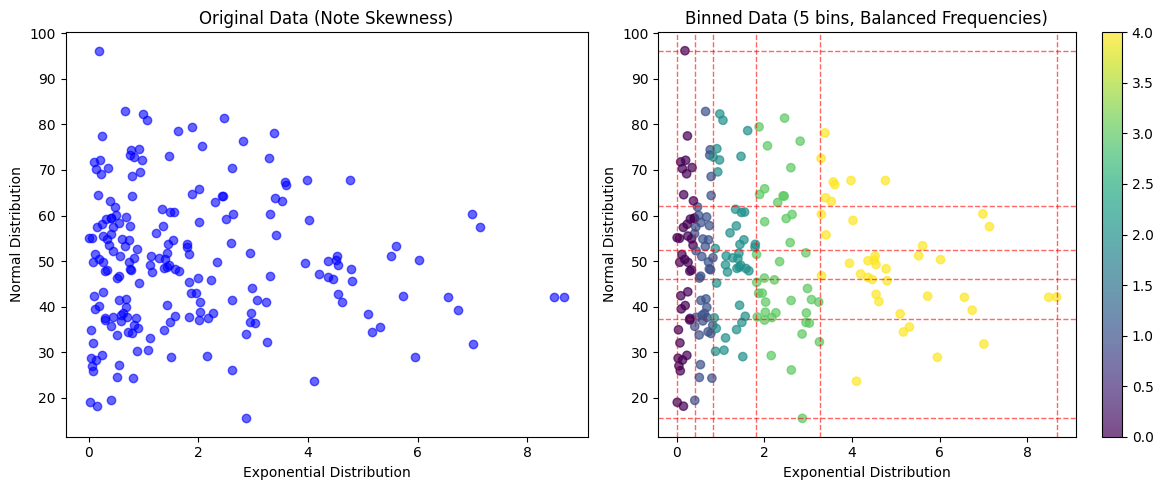


⚖️ Comparison with EqualWidthBinning on skewed data:
EqualFrequency counts: [40 40 40 40 40] (std: 0.0)
EqualWidth counts: [118  48  21   8   5] (std: 41.9)
Balance improvement: infx better


In [12]:
# Visualize binning results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Original data
ax1.scatter(data['exponential'], data['normal'], alpha=0.6, color='blue')
ax1.set_title('Original Data (Note Skewness)')
ax1.set_xlabel('Exponential Distribution')
ax1.set_ylabel('Normal Distribution')

# Binned data with boundaries
binner = EqualFrequencyBinning(n_bins=5)
binner.fit(data[['exponential', 'normal']])
binned = binner.transform(data[['exponential', 'normal']])

scatter = ax2.scatter(data['exponential'], data['normal'], c=binned[:, 0], 
                     cmap='viridis', alpha=0.7)

# Add bin boundaries
for edge in binner.bin_edges_['exponential']:
    ax2.axvline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)
for edge in binner.bin_edges_['normal']:
    ax2.axhline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)

ax2.set_title('Binned Data (5 bins, Balanced Frequencies)')
ax2.set_xlabel('Exponential Distribution')
ax2.set_ylabel('Normal Distribution')
plt.colorbar(scatter, ax=ax2)

plt.tight_layout()
plt.show()

# Compare with EqualWidthBinning
print("\n⚖️ Comparison with EqualWidthBinning on skewed data:")
width_binner = EqualWidthBinning(n_bins=5)
width_binner.fit(data[['exponential']])
width_binned = width_binner.transform(data[['exponential']])

freq_unique, freq_counts = np.unique(binned[:, 0], return_counts=True)
width_unique, width_counts = np.unique(width_binned[:, 0], return_counts=True)

print(f"EqualFrequency counts: {freq_counts} (std: {np.std(freq_counts):.1f})")
print(f"EqualWidth counts: {width_counts} (std: {np.std(width_counts):.1f})")
print(f"Balance improvement: {np.std(width_counts)/np.std(freq_counts):.1f}x better")

## 3. Sklearn Pipeline Integration

In [13]:
# Demonstrate pipeline integration
print("🔗 Sklearn Pipeline Integration")
print("=" * 35)

# Split data for classification
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_class, test_size=0.3, random_state=42
)

# Create pipeline with binning and classification
pipeline = Pipeline([
    ('binner', EqualFrequencyBinning(n_bins=5)),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=42))
])

# Fit and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = (y_pred == y_test).mean()

print(f"✅ Pipeline trained successfully")
print(f"📊 Test accuracy: {accuracy:.3f}")
print(f"🔢 Features binned: {X_train.shape[1]}")

# Show bin edges from pipeline
binner_from_pipeline = pipeline.named_steps['binner']
print(f"\n📏 Bin edges created:")
for i, (col, edges) in enumerate(binner_from_pipeline.bin_edges_.items()):
    print(f"   {col}: {np.round(edges, 2)}")

# Show balanced frequencies
binned_train = binner_from_pipeline.transform(X_train)
print(f"\n📈 Frequency balance check:")
for i, col in enumerate(X_train.columns):
    unique_bins, counts = np.unique(binned_train[:, i], return_counts=True)
    print(f"   {col}: {counts} (std: {np.std(counts):.1f})")

🔗 Sklearn Pipeline Integration
✅ Pipeline trained successfully
📊 Test accuracy: 0.750
🔢 Features binned: 3

📏 Bin edges created:
   feature_1: [-2.9  -1.17 -0.38  0.57  1.18  2.92]
   feature_2: [-3.09 -1.15 -0.01  0.66  1.24  3.97]
   feature_3: [-3.01 -0.7  -0.3   0.05  0.67  1.59]

📈 Frequency balance check:
   feature_1: [28 28 28 28 28] (std: 0.0)
   feature_2: [28 28 28 28 28] (std: 0.0)
   feature_3: [28 28 28 28 28] (std: 0.0)


## 4. Parameter Serialization and Reconstruction

In [14]:
# Demonstrate serialization for model persistence
print("💾 Parameter Serialization & Reconstruction")
print("=" * 45)

# Create and fit original binner
original_binner = EqualFrequencyBinning(n_bins=6)
original_binner.fit(data)
original_result = original_binner.transform(data)

# Serialize parameters
params = original_binner.get_params()
print(f"📋 Serialized parameters: {params}")

# Reconstruct binner from parameters
reconstructed_binner = EqualFrequencyBinning(**params)

# Test reconstruction
reconstructed_result = reconstructed_binner.transform(data)
results_match = np.allclose(original_result, reconstructed_result)

print(f"\n🔍 Reconstruction verification:")
print(f"   ✅ Results identical: {results_match}")
print(f"   📊 Original shape: {original_result.shape}")
print(f"   📊 Reconstructed shape: {reconstructed_result.shape}")

# Test with new skewed data
test_data = pd.DataFrame({
    'exponential': np.random.exponential(3, 50),
    'power_law': np.random.pareto(2, 50), 
    'normal': np.random.normal(60, 20, 50)
})

test_result = reconstructed_binner.transform(test_data)
print(f"\n🔄 Transform new data without refitting:")
print(f"   ✅ Success: {test_result.shape}")
print(f"   🔢 Unique bins: {len(np.unique(test_result))}")

# Check if frequencies are still balanced on new data
print(f"\n📊 Frequency check on new data:")
for i, col in enumerate(test_data.columns):
    unique_bins, counts = np.unique(test_result[:, i], return_counts=True)
    print(f"   {col}: {counts} (std: {np.std(counts):.1f})")

💾 Parameter Serialization & Reconstruction
📋 Serialized parameters: {'n_bins': 6, 'quantile_range': None, 'clip': True, 'preserve_dataframe': False, 'fit_jointly': False, 'bin_edges': {'exponential': [np.float64(0.01107484075187095), np.float64(0.33920211001179074), np.float64(0.7190764330790471), np.float64(1.364361959644428), np.float64(2.058092028014269), np.float64(3.508873017614536), np.float64(8.66829267917464)], 'power_law': [np.float64(0.003388686695181109), np.float64(0.12074303769195519), np.float64(0.3461353347441723), np.float64(0.6821444043173684), np.float64(1.0625465456390661), np.float64(2.1518273935184635), np.float64(21.30185651423275)], 'normal': [np.float64(15.471182528966224), np.float64(35.98259351580406), np.float64(42.06864870787179), np.float64(49.612167830024134), np.float64(55.07912981766955), np.float64(64.37874112731818), np.float64(96.18321212682856)]}, 'bin_representatives': {'exponential': [0.15758014736148537, 0.5196103138347881, 0.887785344832465, 1.62

## 5. Edge Cases and Robustness

In [15]:
# Test edge cases
print("⚠️ Edge Case Testing")
print("=" * 25)

edge_cases = {
    'Extreme outliers': np.concatenate([np.random.normal(0, 1, 95), np.array([100, -100, 200, -200, 500])]),
    'Many duplicates': np.concatenate([np.full(80, 1.0), np.full(20, 2.0)]),
    'Highly skewed': np.random.exponential(0.5, 100),
    'Small dataset': np.random.exponential(1, 10)
}

for case_name, case_data in edge_cases.items():
    print(f"\n🧪 Testing: {case_name}")
    try:
        df_case = pd.DataFrame({'values': case_data})
        binner = EqualFrequencyBinning(n_bins=5)
        binner.fit(df_case)
        result = binner.transform(df_case)
        
        unique_bins, counts = np.unique(result, return_counts=True)
        
        print(f"   ✅ Success: {result.shape}")
        print(f"   📊 Unique bins: {len(unique_bins)}")
        print(f"   📈 Frequencies: {counts} (std: {np.std(counts):.1f})")
        print(f"   📏 Range: [{case_data.min():.3f}, {case_data.max():.3f}]")
        
    except Exception as e:
        print(f"   ❌ Failed: {str(e)}")

# Compare robustness with EqualWidthBinning on extreme outliers
print(f"\n⚖️ Outlier Robustness Comparison:")
outlier_data = np.concatenate([np.random.normal(0, 1, 95), np.array([100, -100, 200, -200, 500])])
df_outliers = pd.DataFrame({'values': outlier_data})

# EqualFrequency
freq_binner = EqualFrequencyBinning(n_bins=5)
freq_result = freq_binner.fit_transform(df_outliers)
freq_unique, freq_counts = np.unique(freq_result, return_counts=True)

# EqualWidth
width_binner = EqualWidthBinning(n_bins=5)
width_result = width_binner.fit_transform(df_outliers)
width_unique, width_counts = np.unique(width_result, return_counts=True)

print(f"EqualFrequency with outliers: {freq_counts} (std: {np.std(freq_counts):.1f})")
print(f"EqualWidth with outliers: {width_counts} (std: {np.std(width_counts):.1f})")
print(f"Robustness advantage: {np.std(width_counts)/np.std(freq_counts):.1f}x better balance")

⚠️ Edge Case Testing

🧪 Testing: Extreme outliers
   ✅ Success: (100, 1)
   📊 Unique bins: 5
   📈 Frequencies: [20 20 20 20 20] (std: 0.0)
   📏 Range: [-200.000, 500.000]

🧪 Testing: Many duplicates
   ✅ Success: (100, 1)
   📊 Unique bins: 2
   📈 Frequencies: [80 20] (std: 30.0)
   📏 Range: [1.000, 2.000]

🧪 Testing: Highly skewed
   ✅ Success: (100, 1)
   📊 Unique bins: 5
   📈 Frequencies: [20 20 20 20 20] (std: 0.0)
   📏 Range: [0.000, 2.700]

🧪 Testing: Small dataset
   ✅ Success: (10, 1)
   📊 Unique bins: 5
   📈 Frequencies: [2 2 2 2 2] (std: 0.0)
   📏 Range: [0.213, 1.403]

⚖️ Outlier Robustness Comparison:
EqualFrequency with outliers: [20 20 20 20 20] (std: 0.0)
EqualWidth with outliers: [ 2 95  2  1] (std: 40.4)
Robustness advantage: infx better balance


## 6. Summary and Best Practices

In [16]:
# Summary and recommendations
print("📝 EqualFrequencyBinning Summary")
print("=" * 40)

recommendations = {
    "✅ Best for": [
        "Highly skewed distributions",
        "Data with outliers and extreme values",
        "Ensuring balanced sample sizes per bin",
        "Machine learning preprocessing pipelines"
    ],
    "⚠️ Use with caution": [
        "Data where interpretable boundaries are critical",
        "Categorical data with many duplicates",
        "When specific quantile cuts are not desired"
    ],
    "💡 Tips": [
        "Start with 5-10 bins for most use cases",
        "Monitor frequency balance to verify effectiveness",
        "Use in sklearn pipelines for consistent preprocessing",
        "Consider data distribution before choosing bin count"
    ]
}

for category, items in recommendations.items():
    print(f"\n{category}:")
    for item in items:
        print(f"  • {item}")

print(f"\n🎯 Key Features Demonstrated:")
features = [
    "Frequency-balanced binning with multiple configurations",
    "Superior handling of skewed and outlier-heavy data",
    "Seamless sklearn pipeline integration",
    "Parameter serialization and model reconstruction",
    "Robust edge case handling"
]

for i, feature in enumerate(features, 1):
    print(f"  {i}. {feature}")

print(f"\n✨ EqualFrequencyBinning demonstration complete!")

📝 EqualFrequencyBinning Summary

✅ Best for:
  • Highly skewed distributions
  • Data with outliers and extreme values
  • Ensuring balanced sample sizes per bin
  • Machine learning preprocessing pipelines

⚠️ Use with caution:
  • Data where interpretable boundaries are critical
  • Categorical data with many duplicates
  • When specific quantile cuts are not desired

💡 Tips:
  • Start with 5-10 bins for most use cases
  • Monitor frequency balance to verify effectiveness
  • Use in sklearn pipelines for consistent preprocessing
  • Consider data distribution before choosing bin count

🎯 Key Features Demonstrated:
  1. Frequency-balanced binning with multiple configurations
  2. Superior handling of skewed and outlier-heavy data
  3. Seamless sklearn pipeline integration
  4. Parameter serialization and model reconstruction
  5. Robust edge case handling

✨ EqualFrequencyBinning demonstration complete!
